In [40]:
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.integrate import cumulative_trapezoid
from scipy.integrate import solve_ivp
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, root_scalar

import sympy as smp
from sympy import symbols, Eq, solve, exp, sqrt, latex, log, integrate, Function, nsolve, srepr, parse_expr, Piecewise, plot, preorder_traversal, collect
import math

import numpy as np
import pandas as pd

import pickle
import matplotlib.pyplot as plt

from datetime import datetime

# Loading Symbols

In [2]:
lambda_ = symbols('lambda')
rho, v_tg, r,c,nu,kappa,Mu,G,X,Z,rs,re = symbols('rho v_tg r c nu kappa Mu G Chi zeta r_s r_e')
mu = Function('mu')(r)
M = Function('M')(r)

# Solve For Lambda and mu from V Analytically 

In [4]:
equation = Eq(v_tg**2 , (1 - sqrt(1 - 2 * lambda_ * rho**2 *c**4* (exp(mu) - 1)) )/ (2 * lambda_ * rho**2*c**2))
equation

Eq(v_tg**2, (1 - sqrt(-2*c**4*lambda*rho**2*(exp(mu(r)) - 1) + 1))/(2*c**2*lambda*rho**2))

In [5]:
lambdaSolution = solve(equation, lambda_)
lambdaSolution[0]

(c**2*(1 - exp(mu(r)))/2 + v_tg**2)/(c**2*rho**2*v_tg**4)

In [6]:
muSolution = solve(equation, mu)
muSolution[0]

log(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2)

# Solving for mu

In [7]:
nu=(1 - sqrt(1 - 2 * lambda_ * rho**2 *c**4* (exp(mu) - 1)) )/ (2 * lambda_ * rho**2*c**2*r)
nu

(1 - sqrt(-2*c**4*lambda*rho**2*(exp(mu(r)) - 1) + 1))/(2*c**2*lambda*r*rho**2)

In [8]:
Fintegrand=r*nu**2
Fintegrand

(1 - sqrt(-2*c**4*lambda*rho**2*(exp(mu(r)) - 1) + 1))**2/(4*c**4*lambda**2*r*rho**4)

In [9]:
Fintegral = integrate(Fintegrand, r)
Fintegral

(Integral(2/r, r) + Integral(-2*sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r) + Integral(2*c**4*lambda*rho**2/r, r) + Integral(-2*c**4*lambda*rho**2*exp(mu(r))/r, r))/(4*c**4*lambda**2*rho**4)

In [10]:
FintegralS=Fintegral.simplify()

In [11]:
FintegralS

(c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(mu(r))/r, r) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r))/(2*c**4*lambda**2*rho**4)

In [12]:
F=2*log(r*c**2/(2*G*M))+lambda_*rho**2*c**4/2*FintegralS
F

2*log(c**2*r/(2*G*M(r))) + (c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(mu(r))/r, r) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r))/(4*lambda*rho**2)

In [13]:
integral1Mu=integrate(exp(F)/(r**2),r)
integral1Mu

c**4*Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r)/(4*G**2)

In [14]:
integral2Mu=integrate(exp(F),r)
integral2Mu

c**4*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r)/(4*G**2)

In [15]:
Mu=F-log(r*(integral1Mu-kappa*rho*integral2Mu))
Mu

-log(r*(-c**4*kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r)/(4*G**2) + c**4*Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r)/(4*G**2))) + 2*log(c**2*r/(2*G*M(r))) + (c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(mu(r))/r, r) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r))/(4*lambda*rho**2)

In [16]:
MuS=Mu.simplify()
MuS

(c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(mu(r))/r, r) + 4*lambda*rho**2*(-log(-c**4*r*(kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r) - Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r))/G**2) + 2*log(c**2*r/(G*M(r)))) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r))/(4*lambda*rho**2)

In [17]:
equationmu = Eq(mu , MuS)
equationmu

Eq(mu(r), (c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(mu(r))/r, r) + 4*lambda*rho**2*(-log(-c**4*r*(kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r) - Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r))/G**2) + 2*log(c**2*r/(G*M(r)))) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r))/(4*lambda*rho**2))

In [18]:
equationmuS = Eq(mu*4*lambda_*rho**2 , MuS*4*lambda_*rho**2)
equationmuS

Eq(4*lambda*rho**2*mu(r), c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(mu(r))/r, r) + 4*lambda*rho**2*(-log(-c**4*r*(kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r) - Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r))/G**2) + 2*log(c**2*r/(G*M(r)))) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r))

In [19]:
equationMu=equationmuS.subs(mu,X)
equationMu

Eq(4*Chi*lambda*rho**2, c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(Chi)/r, r) + 4*lambda*rho**2*(-log(-c**4*r*(kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(Chi)/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(Chi) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r) - Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(Chi)/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(Chi) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r))/G**2) + 2*log(c**2*r/(G*M(r)))) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(Chi) + 2*c**4*lambda*rho**2 + 1)/r, r))

In [23]:
equationLambda=equationMu.subs(mu,muSolution[0])
equationLambda

Eq(4*lambda*rho**2*log(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2), c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral((-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2)/r, r) + 4*lambda*rho**2*(-log(-c**4*r*(kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral((-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2)/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r) - Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral((-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2)/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r))/G**2) + 2*log(c**2*r/(G*M(r)))) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2) + 2*c**4*lambda*rho**2 + 1)/r, r))

# Dumping and loading Equations

In [20]:
equation_str = srepr(equationMu)

with open('EquationMu.txt', 'w') as file:
    file.write(equation_str)

In [24]:
equationLambda_str = srepr(equationLambda)
with open('equationLambda.txt', 'w') as file:
    file.write(equationLambda_str)

In [21]:
F_str = srepr(F)
with open('EquationF.txt', 'w') as file:
    file.write(F_str)

integral1Mu_str = srepr(integral1Mu)
with open('Equationintegral1Mu.txt', 'w') as file:
    file.write(integral1Mu_str)

integral2Mu_str = srepr(integral2Mu)
with open('Equationintegral2Mu.txt', 'w') as file:
    file.write(integral2Mu_str)

In [6]:
with open('EquationF.txt', 'r') as file:
    equation_str = file.read()
FLoaded = parse_expr(equation_str, evaluate=False)

with open('Equationintegral1Mu.txt', 'r') as file:
    equation_str = file.read()
integral1MuLoaded = parse_expr(equation_str, evaluate=False)

with open('Equationintegral2Mu.txt', 'r') as file:
    equation_str = file.read()
integral2MuLoaded = parse_expr(equation_str, evaluate=False)

with open('EquationMu.txt', 'r') as file:
    equation_str = file.read()
muLoaded = parse_expr(equation_str, evaluate=False)
muLoaded=muLoaded.subs(X,mu)
muLoaded

Eq(4*lambda*rho**2*mu(r), c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral(exp(mu(r))/r, r) + 4*lambda*rho**2*(-log(-c**4*r*(kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r) - Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral(exp(mu(r))/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r))/G**2) + 2*log(c**2*r/(G*M(r)))) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*exp(mu(r)) + 2*c**4*lambda*rho**2 + 1)/r, r))

# Working with Constants

## Defining Mass and Density from empirical data for Milkyway

### Putting value of mu from v_tg equation to get lambda implicit equation 

### Working with other constants

### In Natural Units

In [3]:
with open('equationLambda.txt', 'r') as file:
    equation_str = file.read()
equationLambda = parse_expr(equation_str, evaluate=False)
equationLambda

Eq(4*lambda*rho**2*log(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2), c**4*lambda*rho**2*log(r) - c**4*lambda*rho**2*Integral((-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2)/r, r) + 4*lambda*rho**2*(-log(-c**4*r*(kappa*rho*Integral(r**2*exp(c**4*log(r)/4)*exp(-c**4*Integral((-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2)/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r) - Integral(exp(c**4*log(r)/4)*exp(-c**4*Integral((-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2)/r, r)/4)*exp(log(r)/(4*lambda*rho**2))*exp(-Integral(sqrt(-2*c**4*lambda*rho**2*(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2) + 2*c**4*lambda*rho**2 + 1)/r, r)/(4*lambda*rho**2))/M(r)**2, r))/G**2) + 2*log(c**2*r/(G*M(r)))) + log(r) - Integral(sqrt(-2*c**4*lambda*rho**2*(-2*lambda*rho**2*v_tg**4 + 1 + 2*v_tg**2/c**2) + 2*c**4*lambda*rho**2 + 1)/r, r))

In [4]:
 def findLogArgs(expr):
        if expr.func == smp.log:
            return [expr.args[0]]  
        log_args = []
        for arg in expr.args:
            log_args.extend(findLogArgs(arg))  
        return log_args

def ConvertIndefinate2Definate(expr,limits):    
    def Replacer(expr,limits):
        dx=expr.variables
        integrand=expr.function
        result=smp.Integral(integrand,(dx,limits[0],limits[1]))
        return result
   
    for arg in expr.args:            
        if isinstance(arg, smp.Integral):
            replacer=Replacer(arg,limits)
            expr=expr.subs(arg,replacer) 

    logArguments=findLogArgs(expr)
    for logs in logArguments: 
        for arg in logs.args:
            if isinstance(arg, smp.Integral):
                replacer=Replacer(arg,limits)
                expr=expr.subs(arg,replacer) 
                
    return expr


def ConvertIndefinate2DefinateDeep(Expr,Limits): 
    def ConvertIndefinate2Definate1(expr,limits):
        def Replacer(expr,limits):
            dx=expr.variables
            integrand=expr.function
            result=smp.Integral(integrand,(dx,limits[0],limits[1]))
            return result
            
        replaced=False
        for node in preorder_traversal(expr):
            if isinstance(node, smp.Integral) and len(node.args[1])==1:
                replacer=Replacer(node,limits)
                expr=expr.subs(node,replacer)
                replaced=True
                break
        return expr,replaced
    r=True
    while(r):
        Expr,r=ConvertIndefinate2Definate1(Expr,Limits)
    return Expr

In [39]:
def IntegralDeepClean(Expr): 
    def HasNestedIntegral(expr):
        for node in preorder_traversal(expr):
            if isinstance(node, smp.Integral):
                return True
        return False
    
    for node in preorder_traversal(Expr):
         if isinstance(node, smp.Integral):
             nested=HasNestedIntegral(node.function)
             if(not nested):
                 simple=node.simplify()
                 Expr=Expr.replace(node,simple)
    return Expr

def IntegrandDeepClean(Expr): 
    def HasNestedIntegral(expr):
        for node in preorder_traversal(expr):
            if isinstance(node, smp.Integral):
                return True
        return False
    
    for node in preorder_traversal(Expr):
         if isinstance(node, smp.Integral):
             nested=HasNestedIntegral(node.function)
             if(not nested):
                 simple=node.function.simplify()
                 Expr=Expr.replace(node.function,simple)
    return Expr


def IntegralDeepSepration(Expr):
    def dealExponent(expr,dx):
        fun=expr.args[0]
        seps=fun.as_independent(dx,as_Mul=True)
        seprated=exp(seps[0])*exp(seps[1])
        return seprated
        
    def HasNestedIntegral(expr):
        for node in preorder_traversal(expr):
            if isinstance(node, smp.Integral):
                return True
        return False

    def UpgradeIntegral(expr,integrand):
        dx=expr.limits[0]
        return smp.Integral(integrand,(dx[0],dx[1],dx[2])).simplify()
    
    for node in preorder_traversal(Expr):
         if isinstance(node, smp.Integral):
             isnested=HasNestedIntegral(node.function)
             if(not isnested):
                 fun=node.function
                 dx=node.variables[0]
                 for n in preorder_traversal(fun):
                     if n.func == exp:
                         exed= dealExponent(n,dx)
                         fun=fun.replace(n,exed)
                 updatedNode=UpgradeIntegral(node,fun)
                 Expr=Expr.replace(node,updatedNode)
                
    return Expr

def LogCleaning(Expr):
    for node in preorder_traversal(Expr):
        if node.func==log:
            if(len(node.args)==1 and node.args[0].func==exp): 
                
                Expr=Expr.subs(node,node.args[0].args[0])
    return Expr


In [7]:
pc_to_m = 3.086 * 10**16  # Conversion factor from kpc to meters
solar_mass_to_kg = 1.989 * 10**30  # Conversion factor from solar masses to kilograms
year_to_s = 3.154 * 10**7  # Conversion factor from years to seconds



G_mks = 6.674 * 10**-11  # Gravitational constant in m^3 kg^-1 s^-2
c_m_per_s=299792458 # m s^-1
velocity_tg=220*1000 # m s^-1
rhoSI=4.66*10**(-4)*1.989 * 10**30*(1/( 3.086 * 10**16)**3)
rSI=31.5*1000*3.086 * 10**16


# Conversion
G_N = G_mks / ((pc_to_m**3) / (solar_mass_to_kg * (year_to_s**2)))
c_N = c_m_per_s * (1 / pc_to_m) * year_to_s
v_N = velocity_tg * (1 / pc_to_m) * year_to_s
r_N=rSI/pc_to_m
rho_N=rhoSI *(1/(solar_mass_to_kg))*(pc_to_m**3)

constants = {G:G_N ,kappa: 1, rho: rho_N,c:c_N,v_tg:v_N}
print(r_N)
constants

31499.999999999996


{G: 4.493208773765747e-15,
 kappa: 1,
 rho: 0.0004660000000000001,
 c: 0.30639838384057033,
 v_tg: 0.00022484769928710305}

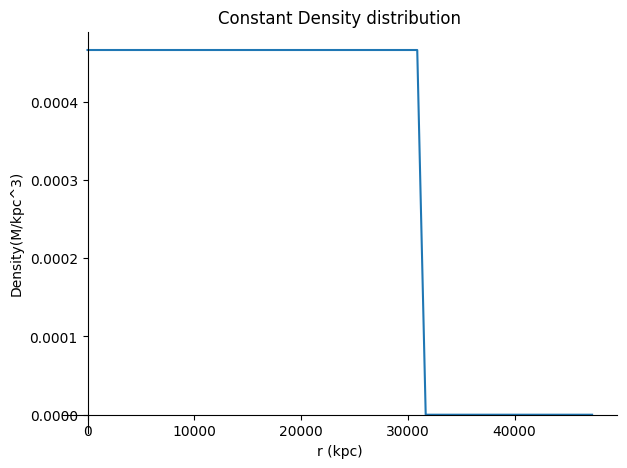

In [8]:
densityDistributionN = Piecewise((rho_N, (r >= 0) & (r <= r_N)), (0, True))
densityDistributionNPlot=plot(densityDistributionN,(r,0,1.5*r_N),show=False,title='Constant Density distribution',ylabel='Density(M/kpc^3)',xlabel='r (kpc)')
densityDistributionNPlot.save('Density_Profile.png')
densityDistributionNPlot.show()

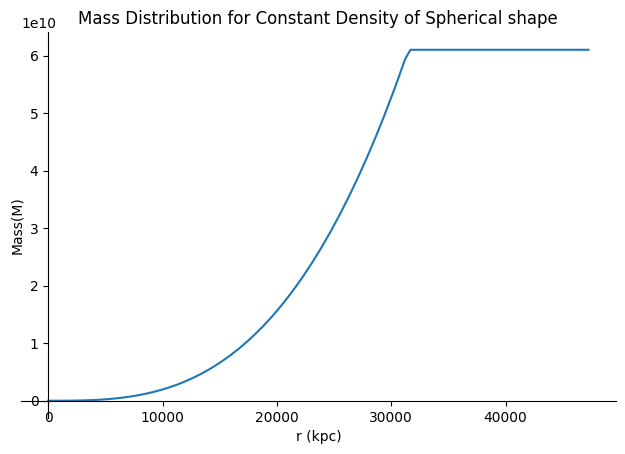

In [9]:
insideDistribution=(4/3)*smp.pi*r**3*rho_N
outsideDistribution=(4/3)*np.pi*r_N**3*rho_N
massDistributionN = Piecewise((insideDistribution, (r >= 0) & (r <= r_N)), (outsideDistribution, True))
massDistributionNPlot=plot(massDistributionN,(r,0,1.5*r_N),show=False,title='Mass Distribution for Constant Density of Spherical shape',ylabel='Mass(M)',xlabel='r (kpc)')
massDistributionNPlot.save('Mass_Profile.png')
massDistributionNPlot.show()

In [10]:
equationLambdaValuedN = equationLambda.subs(constants)
equationLambdaValuedN

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), 8.68624e-7*lambda*(-log(-4.36548684931048e+26*r*(-Integral(r**0.00220336217396836*exp(1151246.10878815*log(r)/lambda)*exp(-1151246.10878815*Integral(sqrt(-3.82778653000218e-9*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda) + 3.82778653000218e-9*lambda + 1)/r, r)/lambda)*exp(-0.00220336217396836*Integral((1.00000107704525 - 1.11008343338313e-21*lambda)/r, r))/M(r)**2, r) + 0.000466*Integral(r**2.00220336217397*exp(1151246.10878815*log(r)/lambda)*exp(-1151246.10878815*Integral(sqrt(-3.82778653000218e-9*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda) + 3.82778653000218e-9*lambda + 1)/r, r)/lambda)*exp(-0.00220336217396836*Integral((1.00000107704525 - 1.11008343338313e-21*lambda)/r, r))/M(r)**2, r))) + 2*log(20893747508071.6*r/M(r))) + 1.91389326500109e-9*lambda*log(r) - 1.91389326500109e-9*lambda*Integral((1.00000107704525 - 1.11008343338313e-21*lambda)/r, r) + log(r) - Integral(sqrt(-3.8277865300021

In [11]:
equationLambdaValuedN1=equationLambdaValuedN.subs(M,insideDistribution)
equationLambdaValuedN1

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), 8.68624e-7*lambda*(2*log(3.3627276032304e+16/(pi*r**2)) - log(-4.36548684931048e+26*r*(-Integral(2590303.74477334*exp(1151246.10878815*log(r)/lambda)*exp(-1151246.10878815*Integral(sqrt(-3.82778653000218e-9*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda) + 3.82778653000218e-9*lambda + 1)/r, r)/lambda)*exp(-0.00220336217396836*Integral((1.00000107704525 - 1.11008343338313e-21*lambda)/r, r))/(pi**2*r**5.99779663782603), r) + 0.000466*Integral(2590303.74477334*exp(1151246.10878815*log(r)/lambda)*exp(-1151246.10878815*Integral(sqrt(-3.82778653000218e-9*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda) + 3.82778653000218e-9*lambda + 1)/r, r)/lambda)*exp(-0.00220336217396836*Integral((1.00000107704525 - 1.11008343338313e-21*lambda)/r, r))/(pi**2*r**3.99779663782603), r)))) + 1.91389326500109e-9*lambda*log(r) - 1.91389326500109e-9*lambda*Integral((1.00000107704525 - 1.11008343338313e-21*lambda)/r, r) + log

In [12]:
a0=equationLambdaValuedN1.rhs.args[0]
a0L=ConvertIndefinate2DefinateDeep(IntegralDeepClean(a0),(rs,re))
a1=equationLambdaValuedN1.rhs.args[1]
a1L=ConvertIndefinate2DefinateDeep(IntegralDeepClean(a1),(rs,re))
a2=equationLambdaValuedN1.rhs.args[2]
a2L=ConvertIndefinate2DefinateDeep(IntegralDeepClean(a2),(rs,re))
a3=equationLambdaValuedN1.rhs.args[3]
a3L=ConvertIndefinate2DefinateDeep(IntegralDeepClean(a3),(rs,re))
a4=equationLambdaValuedN1.rhs.args[4]
a4L=ConvertIndefinate2DefinateDeep(IntegralDeepClean(a4),(rs,re))


equationLambdaValuedN2=equationLambdaValuedN1.subs({a0:a0L,a1:a1L,a2:a2L,a3:a3L,a4:a4L})
equationLambdaValuedN2

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), -1.91389326500109e-9*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda)*log(r) + 8.68624e-7*lambda*(2*log(3.3627276032304e+16/(pi*r**2)) - log(-4.36548684931048e+26*r*(-Integral(2590303.74477334*exp(1151246.10878815*log(r)/lambda)*exp(-0.00220336217396836*(1.00000107704525 - 1.11008343338313e-21*lambda)*log(r))*exp(-1151246.10878815*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1)*log(r)/lambda)/(pi**2*r**5.99779663782603), (r, r_s, r_e)) + 0.000466*Integral(2590303.74477334*exp(1151246.10878815*log(r)/lambda)*exp(-0.00220336217396836*(1.00000107704525 - 1.11008343338313e-21*lambda)*log(r))*exp(-1151246.10878815*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1)*log(r)/lambda)/(pi**2*r**3.99779663782603), (r, r_s, r_e))))) + 1.91389326500109e-9*lambda*log(r) - sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1)*log(r) + log(r))

In [13]:
rstart=0.0000000001
rend=r_N
atR=r_N
rConstants={r:atR,rs:rstart,re:rend}
equationLambdaValuedN3=equationLambdaValuedN2.subs(rConstants)
equationLambdaValuedN3

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), -1.98236142330244e-8*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda) + 8.68624e-7*lambda*(-log(1.3751283575328e+31*Integral(2590303.74477334*exp(1151246.10878815*log(r)/lambda)*exp(-0.00220336217396836*(1.00000107704525 - 1.11008343338313e-21*lambda)*log(r))*exp(-1151246.10878815*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1)*log(r)/lambda)/(pi**2*r**5.99779663782603), (r, 1.0e-10, 31500.0)) - 6.40809814610285e+27*Integral(2590303.74477334*exp(1151246.10878815*log(r)/lambda)*exp(-0.00220336217396836*(1.00000107704525 - 1.11008343338313e-21*lambda)*log(r))*exp(-1151246.10878815*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1)*log(r)/lambda)/(pi**2*r**3.99779663782603), (r, 1.0e-10, 31500.0))) + 2*log(33889922.9350507/pi)) + 1.98236142330244e-8*lambda - 10.3577428248137*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1) + 10.3577428248137)

In [14]:
a0=equationLambdaValuedN3.rhs.args[0]
a0L=IntegrandDeepClean(a0)
a1=equationLambdaValuedN3.rhs.args[1]
a1L=IntegrandDeepClean(a1)
a2=equationLambdaValuedN3.rhs.args[2]
a2L=IntegrandDeepClean(a2)
a3=equationLambdaValuedN3.rhs.args[3]
a3L=IntegrandDeepClean(a3)
a4=equationLambdaValuedN3.rhs.args[4]
a4L=IntegrandDeepClean(a4)


equationLambdaValuedN4=equationLambdaValuedN3.subs({a0:a0L,a1:a1L,a2:a2L,a3:a3L,a4:a4L})
equationLambdaValuedN4

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), -1.98236142330244e-8*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda) + 8.68624e-7*lambda*(-log(1.3751283575328e+31*Integral(2590303.74477334*exp((2.44591584706532e-24*lambda - 0.00220336454708913 - 1151246.10878815*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1)/lambda + 1151246.10878815/lambda)*log(r))/(pi**2*r**5.99779663782603), (r, 1.0e-10, 31500.0)) - 6.40809814610285e+27*Integral(2590303.74477334*exp((2.44591584706532e-24*lambda - 0.00220336454708913 - 1151246.10878815*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1)/lambda + 1151246.10878815/lambda)*log(r))/(pi**2*r**3.99779663782603), (r, 1.0e-10, 31500.0))) + 2*log(33889922.9350507/pi)) + 1.98236142330244e-8*lambda - 10.3577428248137*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1) + 10.3577428248137)

In [19]:
equationLambdaValuedN5=IntegralDeepSepration(equationLambdaValuedN4)
equationLambdaValuedN5

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), -1.98236142330244e-8*lambda*(1.00000107704525 - 1.11008343338313e-21*lambda) + 8.68624e-7*lambda*(-log(8.45050576294127e+76*exp((2.44591584706532e-24*lambda**2 - 1151246.10878815*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1) + 1151246.10878815)/lambda)/pi**2) + 2*log(33889922.9350507/pi)) + 1.98236142330244e-8*lambda - 10.3577428248137*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1) + 10.3577428248137)

In [44]:
equationLambdaValuedN6=LogCleaning(equationLambdaValuedN5.simplify()).simplify()
equationLambdaValuedN6

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), 1.98812845431171e-29*lambda**2 - 0.000123738474127001*lambda - 9.35774282481372*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1) + 9.35774282481372)

In [48]:
equationLambdaValuedSimplified_str = srepr(equationLambdaValuedN4)
with open('equationLambdaValued.txt', 'w') as file:
    file.write(equationLambdaValuedSimplified_str)

equationLambdaValuedSimplified_str = srepr(equationLambdaValuedN6)
with open('equationLambdaValued1.txt', 'w') as file:
    file.write(equationLambdaValuedSimplified_str)

# Finding Lambda Value Numerically

In [5]:
with open('equationLambdaValued1.txt', 'r') as file:
    equation_str = file.read()
equationLambdaValuedSimplified = parse_expr(equation_str, evaluate=False)
equationLambdaValuedSimplified

Eq(8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda), 1.98812845431171e-29*lambda**2 - 0.000123738474127001*lambda - 9.35774282481372*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1) + 9.35774282481372)

In [7]:
equationLambdaValuedSimplified=Eq(equationLambdaValuedSimplified.lhs-equationLambdaValuedSimplified.lhs,equationLambdaValuedSimplified.rhs-equationLambdaValuedSimplified.lhs)
equationLambdaValuedSimplified=Eq(equationLambdaValuedSimplified.rhs,equationLambdaValuedSimplified.lhs)
equationLambdaValuedSimplified

Eq(1.98812845431171e-29*lambda**2 - 8.68624e-7*lambda*log(1.00000107704525 - 1.11008343338313e-21*lambda) - 0.000123738474127001*lambda - 9.35774282481372*sqrt(4.24916241348253e-30*lambda**2 - 4.12269931631435e-15*lambda + 1) + 9.35774282481372, 0)

In [28]:
func = smp.lambdify((lambda_), equationLambdaValuedSimplified.lhs, 'numpy')
def numerical_eq(lambda_):
    return func(lambda_)

In [47]:
Guess=10**20
Values=[]

brentqSol = root_scalar(numerical_eq, bracket=[-Guesses[len(Guesses)-1], Guesses[len(Guesses)-1]], method='brentq')
lambdaValue=brentqSol.root
print('Lambda Value is',lambdaValue)
brentqSol

Lambda Value is 1.9699797348948778e-12


      converged: True
           flag: converged
 function_calls: 6
     iterations: 5
           root: 1.9699797348948778e-12